# "Profitable Free App Profiles for iOS and Android"

- categories: [python, pandas, matplotlib]

_by Migs Germar_

Welcome. I wrote this notebook as a guided project in the [Dataquest](https://dataquest.io) Data Scientist Path. The hypothetical app company situation and project flow came from the course. However, all of the text and code themselves are written by me.

Originally, this notebook was intended for Python beginners who would use a list-of-lists for a dataset. However, I used `pandas` DataFrames and `matplotlib.pyplot` graphs because I already had some experience with them beforehand.

# Overview

In this project, we will be working on data about different types of apps and their corresponding number of users. The goal is to determine which apps can best attract the largest number of users.

This will help a hypothetical app company make decisions regarding what apps to develop in the near future. This app company only makes free apps directed toward an English-speaking audience. This information will be considered in the criteria.

# Package Installs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# for fastpages
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# App Data Overview

First, here is the small sample of data that will be used.

- One dataset lists over 10,000 Android apps on Google Play.
- One dataset lists over 7,000 iOS apps on the App Store.

In [3]:
def explore_data(df, start, end, rows_and_columns=False):
    
    """Prints a slice of rows from a pandas DataFrame.
    Optionally prints the numbers of rows and columns
    in the whole dataset."""
    
    df_slice = df.iloc[start:end]    
    print(df_slice)

    if rows_and_columns:
        print('\nNumber of rows:', len(df))
        print('Number of columns:', len(df.columns))

data_apple = pd.read_csv("./2021-05-08-Files/AppleStore.csv", header = 0)
data_google = pd.read_csv("./2021-05-08-Files/googleplaystore.csv", header = 0)
    
print("Apple App Store data\n")
explore_data(data_apple, 0, 6, True)

print("\n\nGoogle Play Store data\n")
explore_data(data_google, 0, 6, True)

Apple App Store data

          id               track_name  size_bytes currency  price  \
0  284882215                 Facebook   389879808      USD    0.0   
1  389801252                Instagram   113954816      USD    0.0   
2  529479190           Clash of Clans   116476928      USD    0.0   
3  420009108               Temple Run    65921024      USD    0.0   
4  284035177  Pandora - Music & Radio   130242560      USD    0.0   
5  429047995                Pinterest    74778624      USD    0.0   

   rating_count_tot  rating_count_ver  user_rating  user_rating_ver      ver  \
0           2974676               212          3.5              3.5     95.0   
1           2161558              1289          4.5              4.0    10.23   
2           2130805               579          4.5              4.5  9.24.12   
3           1724546              3842          4.5              4.0    1.6.2   
4           1126879              3594          4.0              4.5    8.4.1   
5           10

- The Apple dataset has 7197 rows (apps), and 16 columns.
- The Google Play dataset has 10841 rows (apps), and 13 columns.

The Google Play headers are self-explanatory, but some Apple headers are ambiguous. For more information on the column header meanings, we can read the Kaggle documentations.

[Google Play Store Apps](https://www.kaggle.com/lava18/google-play-store-apps)

[Mobile App Store ( 7200 apps)](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps)

The second link describes the columns as follows:

- "id" : App ID
- "track_name": App Name
- "size_bytes": Size (in Bytes)
- "currency": Currency Type
- "price": Price amount
- "ratingcounttot": User Rating counts (for all version)
- "ratingcountver": User Rating counts (for current version)
- "user_rating" : Average User Rating value (for all version)
- "userratingver": Average User Rating value (for current version)
- "ver" : Latest version code
- "cont_rating": Content Rating
- "prime_genre": Primary Genre
- "sup_devices.num": Number of supporting devices
- "ipadSc_urls.num": Number of screenshots showed for display
- "lang.num": Number of supported languages
- "vpp_lic": Vpp Device Based Licensing Enabled

These are the kind of data that the Apple App Store dataset contains.

# Data Cleaning

The data must first be cleaned of unwanted datapoints.

## Inaccurate Data

[This Kaggle discussion](https://www.kaggle.com/lava18/google-play-store-apps/discussion/164101) about the Google Play dataset indicates that row 10472 (excluding the header) has an error.

Below, I have printed row 0 and row 10472 so that these can be compared.

In [4]:
print(data_google.iloc[[0, 10472]])
print("\nLength of inaccurate row:", len(data_google.iloc[10472]))

                                                  App        Category  Rating  \
0      Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
10472         Life Made WI-Fi Touchscreen Photo Frame             1.9    19.0   

      Reviews    Size Installs  Type     Price Content Rating  \
0         159     19M  10,000+  Free         0       Everyone   
10472    3.0M  1,000+     Free     0  Everyone            NaN   

                  Genres     Last Updated Current Ver   Android Ver  
0           Art & Design  January 7, 2018       1.0.0  4.0.3 and up  
10472  February 11, 2018           1.0.19  4.0 and up           NaN  

Length of inaccurate row: 13


As we look at row 10472 in the context of the column headers and row 0, the following things become clear.

- The "Category" value is missing entirely. Thus, all values to the right have been shifted leftward.
- The "Android Ver" value is missing.

Thus, this row will be removed.

In [5]:
# This if-statement prevents more rows from being deleted
# if the cell is run again.
if data_google.iloc[10472, 0] == 'Life Made WI-Fi Touchscreen Photo Frame':
    data_google.drop(10472, inplace = True)
    print("The inaccurate row was deleted.")

The inaccurate row was deleted.


## Duplicate Data

There are also duplicate app entries in the Google Play dataset. We can consider a row as a duplicates if another row exists that has the same "App" value.

Here, I count the total number of duplicate rows. This turns out to be 1979 rows.

In [6]:
def count_duplicates(df, col_name, prt = False):
    
    """Count the number of duplicate rows in a DataFrame.
    `col_name` is the name of the column to be used as a basis
    for duplicate values."""
    
    all_apps = {}
    
    for index, row in df.iterrows():
        name = row[col_name]
        all_apps.setdefault(name, []).append(index)
            
    duplicate_inds = [ind
                      for lst in all_apps.values()
                      for ind in lst
                      if len(lst) > 1]
    
    n_duplicates = len(duplicate_inds)

    print("Duplicates:", n_duplicates, "\n")
    
    if prt:
        print(df.iloc[duplicate_inds])
    
count_duplicates(data_google, "App")

Duplicates: 1979 



As an example, there are 4 rows for Instagram:

In [7]:
ig_filter = data_google["App"] == "Instagram"
ig_rows = data_google.where(ig_filter).dropna()
print(ig_rows)

            App Category  Rating   Reviews                Size  \
2545  Instagram   SOCIAL     4.5  66577313  Varies with device   
2604  Instagram   SOCIAL     4.5  66577446  Varies with device   
2611  Instagram   SOCIAL     4.5  66577313  Varies with device   
3909  Instagram   SOCIAL     4.5  66509917  Varies with device   

            Installs  Type Price Content Rating  Genres   Last Updated  \
2545  1,000,000,000+  Free     0           Teen  Social  July 31, 2018   
2604  1,000,000,000+  Free     0           Teen  Social  July 31, 2018   
2611  1,000,000,000+  Free     0           Teen  Social  July 31, 2018   
3909  1,000,000,000+  Free     0           Teen  Social  July 31, 2018   

             Current Ver         Android Ver  
2545  Varies with device  Varies with device  
2604  Varies with device  Varies with device  
2611  Varies with device  Varies with device  
3909  Varies with device  Varies with device  


Looking closely, we can see that duplicate rows are not exactly identical. The "Reviews" column, which shows the total number of reviews of the app, has different values.

It can be inferred that the row with the largest value is the newest entry for the app. Therefore, all duplicate rows will be dropped except for the ones with the largest "Reviews" values.

In [8]:
def remove_duplicates(df, name_col, reviews_col):

    # Each key-value pair will follow the format:
    # {"App Name": maximum number of reviews among all duplicates}
    reviews_max = {}

    for index, row in df.iterrows():
        name = row[name_col]
        n_reviews = int(row[reviews_col])

        if n_reviews > reviews_max.get(name, -1):
            reviews_max[name] = n_reviews

    # List of duplicate indices to drop,
    # excluding the row with the highest number of reviews
    # among that app's duplicate rows.
    indices_to_drop = []

    # Rows with names that have already been added into this list
    # will be dropped.
    already_added = []

    for index, row in df.iterrows():
        name = row[name_col]
        n_reviews = int(row[reviews_col])

        if (name not in already_added) and (n_reviews == reviews_max[name]):
            already_added.append(name)
        else:
            indices_to_drop.append(index)

    # Remove duplicates and return the clean dataset.
    clean = df.drop(indices_to_drop)
    return clean

android_clean = remove_duplicates(data_google, "App", "Reviews")
print(android_clean.shape)

(9659, 13)


After duplicates were removed, the Google Play dataset was left with 9659 rows.

As for the Apple App Store dataset, there are 4 duplicate rows.

In [9]:
count_duplicates(data_apple, "track_name", prt = True)

Duplicates: 4 

              id           track_name  size_bytes currency  price  \
2948  1173990889  Mannequin Challenge   109705216      USD    0.0   
4463  1178454060  Mannequin Challenge    59572224      USD    0.0   
4442   952877179    VR Roller Coaster   169523200      USD    0.0   
4831  1089824278    VR Roller Coaster   240964608      USD    0.0   

      rating_count_tot  rating_count_ver  user_rating  user_rating_ver    ver  \
2948               668                87          3.0              3.0    1.4   
4463               105                58          4.0              4.5  1.0.1   
4442               107               102          3.5              3.5  2.0.0   
4831                67                44          3.5              4.0   0.81   

     cont_rating prime_genre  sup_devices.num  ipadSc_urls.num  lang.num  \
2948          9+       Games               37                4         1   
4463          4+       Games               38                5         1   
4442

The "rating_count_tot" column in the Apple App Store dataset is like the "Reviews" column in the Google Play dataset. It tells the total number of reviews so far. Therefore, Apple App Store dataset duplicates can be removed by keeping the rows with the highest rating count totals.

In [10]:
ios_clean = remove_duplicates(data_apple, "track_name", "rating_count_tot")
print(ios_clean.shape)

(7195, 16)


From 7197 rows, there are now 7195 rows in the Apple App Store dataset.

## Non-English Apps

The hypothetical app company who will use this analysis is a company that only makes apps in English. Thus, all apps with non-English titles shall be removed from the datasets.

The task now is to identify titles which are not in English. It is known that in the [ASCII table](https://theasciicode.com.ar/), the characters most commonly used in English are within codes 0 to 127. Some English app titles may have special characters or emojis, though, so I will only remove titles which have more than 3 characters outside of the normal range.

In [11]:
def is_english(text):
    unicode = [ord(char) for char in text]
    normal = [(code >= 0 and code <= 127) for code in unicode]
    non_english = len(text) - sum(normal)

    return non_english <= 3

def keep_english(df, name_col):
    
    """Return a new DataFrame containing only rows with English names."""
    
    remove_indices = []
    
    for index, row in df.iterrows():
        name = row[name_col]
        if not is_english(name):
            remove_indices.append(index)
            
    return df.drop(remove_indices)

android_clean = keep_english(android_clean, "App")
ios_clean = keep_english(ios_clean, "track_name")

print("Google Play Store Dataset:", android_clean.shape)
print("Apple App Store Dataset:", ios_clean.shape)

Google Play Store Dataset: (9614, 13)
Apple App Store Dataset: (6181, 16)


Now, there are only English apps in both datasets.

## Paid Apps

As mentioned earlier, the app company only makes free apps. Therefore, data on paid apps is irrelevant to this analysis. Paid apps shall be identified and removed from both datasets.

In [12]:
def remove_paid(df, price_col):
    
    """Return a new DataFrame without paid apps."""
    
    remove_indices = []
    
    for index, row in df.iterrows():
        price = str(row[price_col])
        
        # Keep characters that are numeric or periods.
        price = float(re.sub("[^0-9.]", "", price))
        
        if price != 0.0:
            remove_indices.append(index)
            
    return df.drop(remove_indices)
        
android_clean = remove_paid(android_clean, "Price")
ios_clean = remove_paid(ios_clean, "price")

print("Google Play Store Dataset:", android_clean.shape)
print("Apple App Store Dataset:", ios_clean.shape)

Google Play Store Dataset: (8864, 13)
Apple App Store Dataset: (3220, 16)


Now that the datasets have been cleaned, we can proceed with our main objective, which is to determine a profitable app profile.

#  App Company's Context
​
Before thinking of an app profile, we must know the context of the app company so that we can align our analysis with it.
​
Since they only develop free apps, they get revenue from in-app advertisements. Thus, they rely on having a large number of users so that they can generate more revenue.
​
An app should ideally also be successful on both Google Play Store and the Apple App Store. The reason is that the (hypothetical) company has the following 3-step validation strategy:
​
>1. Build a minimal Android version of the app, and add it to Google Play.
>2. If the app has a good response from users, we develop it further.
>3. If the app is profitable after six months, we build an iOS version of the app and add it to the App Store.
​
# Common App Genres
​
With these criteria in mind, the first step would be to find out which genres of apps are most common in both app markets. If an app genre is common, then there may be high demand for it among users.
​
Let us now look at the column headers for both datasets to see which columns can give information about genres.

In [13]:
print("Google Play Store")
print(android_clean.iloc[0])

print("\nApple App Store")
print(ios_clean.iloc[0])

Google Play Store
App               Photo Editor & Candy Camera & Grid & ScrapBook
Category                                          ART_AND_DESIGN
Rating                                                       4.1
Reviews                                                      159
Size                                                         19M
Installs                                                 10,000+
Type                                                        Free
Price                                                          0
Content Rating                                          Everyone
Genres                                              Art & Design
Last Updated                                     January 7, 2018
Current Ver                                                1.0.0
Android Ver                                         4.0.3 and up
Name: 0, dtype: object

Apple App Store
id                          284882215
track_name                   Facebook
size_bytes           

For Google Play, some columns that seem relevant are "Category" and "Genres". For the Apple App Store, the relevant column is "prime_genre".

We can determine the most common genres by using frequency tables of the mentioned columns.

In [14]:
def freq_table(df, label):
    """Return a frequency table of the values in a column of a DataFrame."""
    col = df[label]
    freq = {}
    
    for value in col:
        freq.setdefault(value, 0)
        freq[value] += 1
        
    for key in freq:
        freq[key] /= len(df) / 100
        
    freq_series = pd.Series(freq).sort_values(ascending = False)
    
    return freq_series

google_categories = freq_table(android_clean, "Category")
google_genres = freq_table(android_clean, "Genres")
apple_genres = freq_table(ios_clean, "prime_genre")

print("Google Play Categories")
print(google_categories[:5])
print("\nGoogle Play Genres")
print(google_genres[:5])
print("\nApple Genres")
print(apple_genres[:5])

Google Play Categories
FAMILY       18.907942
GAME          9.724729
TOOLS         8.461191
BUSINESS      4.591606
LIFESTYLE     3.903430
dtype: float64

Google Play Genres
Tools            8.449910
Entertainment    6.069495
Education        5.347473
Business         4.591606
Productivity     3.892148
dtype: float64

Apple Genres
Games                58.136646
Entertainment         7.888199
Photo & Video         4.968944
Education             3.664596
Social Networking     3.291925
dtype: float64


The first 5 rows of each frequency table are shown above.

## Apple App Store: Prime Genres

First, the frequency table of Apple App Store prime genres shall be analyzed. Below, I have ordered the table by frequency, descending.

Games                58.136646
Entertainment         7.888199
Photo & Video         4.968944
Education             3.664596
Social Networking     3.291925
Shopping              2.608696
Utilities             2.515528
Sports                2.142857
Music                 2.049689
Health & Fitness      2.018634
Productivity          1.739130
Lifestyle             1.583851
News                  1.335404
Travel                1.242236
Finance               1.118012
Weather               0.869565
Food & Drink          0.807453
Reference             0.559006
Business              0.527950
Book                  0.434783
Navigation            0.186335
Medical               0.186335
Catalogs              0.124224
dtype: float64


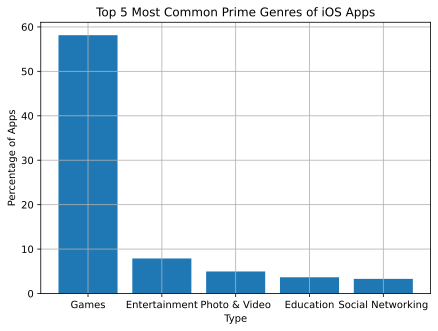

In [15]:
def bar_n(series, title, ylabel, n = 5, shorten = False):

    """Takes a Pandas Series.
    Shows a Pyplot bar graph of the first n values.
    Uses the series indices as the tick labels.
    Specify the title and ylabel."""
    
    ticks = list(series[:n].index)
    if shorten:
        ticks = [text[:8] + "..." for text in ticks]
    
    plt.figure(figsize = (2+n, 5))
    plt.bar(
        x = range(n),
        height = series[:n],
        tick_label = ticks,
    )

    plt.title(title)
    plt.xlabel("Type")
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.show()

print(apple_genres)

bar_n(
    apple_genres,
    "Top 5 Most Common Prime Genres of iOS Apps",
    "Percentage of Apps",
)

The top 5 most common prime genres in the Apple App Store are Games, Entertainment, Photo & Video, Education, and Social Networking. Games are at the top, occupying over 58% of all apps. This is a much higher percentage than any other single genre occupies.

The general impression is that there are many more apps in entertainment-related genres compared to practical genres.

## Google Play Store: Categories

Next, below is the frequency table for Google Play Store app categories.

FAMILY                 18.907942
GAME                    9.724729
TOOLS                   8.461191
BUSINESS                4.591606
LIFESTYLE               3.903430
PRODUCTIVITY            3.892148
FINANCE                 3.700361
MEDICAL                 3.531137
SPORTS                  3.395758
PERSONALIZATION         3.316787
COMMUNICATION           3.237816
HEALTH_AND_FITNESS      3.079874
PHOTOGRAPHY             2.944495
NEWS_AND_MAGAZINES      2.797834
SOCIAL                  2.662455
TRAVEL_AND_LOCAL        2.335289
SHOPPING                2.245036
BOOKS_AND_REFERENCE     2.143502
DATING                  1.861462
VIDEO_PLAYERS           1.793773
MAPS_AND_NAVIGATION     1.398917
FOOD_AND_DRINK          1.240975
EDUCATION               1.162004
ENTERTAINMENT           0.958935
LIBRARIES_AND_DEMO      0.936372
AUTO_AND_VEHICLES       0.925090
HOUSE_AND_HOME          0.823556
WEATHER                 0.800993
EVENTS                  0.710740
PARENTING               0.654332
ART_AND_DE

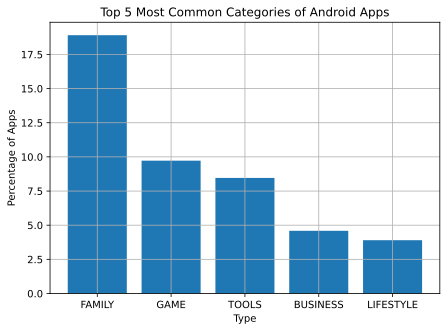

In [16]:
print(google_categories)

bar_n(
    google_categories,
    "Top 5 Most Common Categories of Android Apps",
    "Percentage of Apps",
)

The picture here seems to be different. The most common category is Family occupying almost 19% of all apps, followed by Game, Tools, Business, and Lifestyle.

Generally, the table suggests that practical app categories are more common in Google Play than in the Apple App Store.

## Google Play Store: Genres

Lastly, below is the frequency table for Google Play Store app genres.

Tools                                8.449910
Entertainment                        6.069495
Education                            5.347473
Business                             4.591606
Productivity                         3.892148
                                       ...   
Travel & Local;Action & Adventure    0.011282
Art & Design;Action & Adventure      0.011282
Casual;Music & Video                 0.011282
Strategy;Action & Adventure          0.011282
Strategy;Creativity                  0.011282
Length: 114, dtype: float64


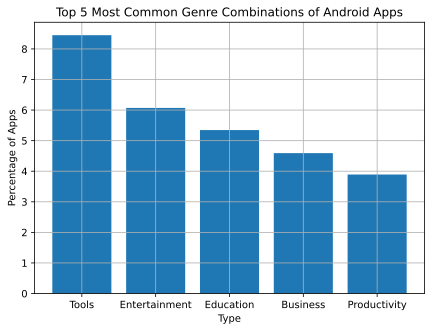

In [17]:
print(google_genres)

bar_n(
    google_genres,
    "Top 5 Most Common Genre Combinations of Android Apps",
    "Percentage of Apps",
)

There are 114 genres in this table, so it is not fully displayed. However, it would appear that the top genres are Tools (8%), Entertainment, Education, Business, and Lifestyle. Like with the categories, practical apps are very common.

However, I noticed something special about this frequency table. Some genres are actually combinations of multiple genres, separated by semi-colons. If I can extract and count individual genres from these combined genres, then I can get a more accurate idea of app genres in the Google Play Store.

Note that this frequency table will show numbers instead of percentages, because some apps have multiple genres. The percentages would not add up to 100%.

Tools                      750
Education                  606
Entertainment              569
Business                   407
Lifestyle                  347
Productivity               345
Finance                    328
Medical                    313
Sports                     309
Personalization            294
Communication              288
Action                     284
Health & Fitness           275
Photography                261
News & Magazines           248
Social                     236
Casual                     210
Travel & Local             207
Shopping                   199
Books & Reference          191
Simulation                 191
Arcade                     176
Dating                     165
Video Players & Editors    160
Maps & Navigation          124
Puzzle                     121
Food & Drink               110
Racing                     104
Role Playing                91
Educational                 88
Strategy                    84
Libraries & Demo            83
Auto & V

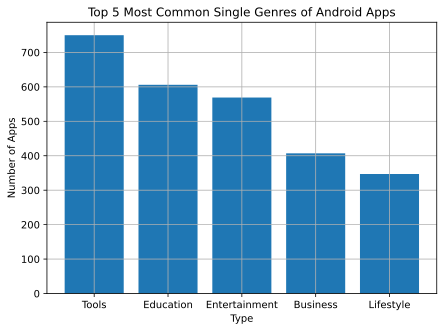

In [18]:
freq = {}
for value in android_clean["Genres"]:
    genres = value.split(";")
    for genre in genres:
        freq.setdefault(genre, 0)
        freq[genre] += 1

google_genres_split = pd.Series(freq).sort_values(ascending = False)

print(google_genres_split)

bar_n(
    google_genres_split,
    "Top 5 Most Common Single Genres of Android Apps",
    "Number of Apps",
)

It can be seen that the frequency table has slightly different placements now. However, the top genres are still Tools, Education, Entertainment, Business, and Lifestyle. Practical app genres are very common in the Google Play Store. They are more common here than in the Apple App Store.

Based on the results, the Google Play Store has a selection of apps that is more balanced between entertainment and practicality.

___

Going back to the the frequency table of Categories, since it seems that each Category represents a group of Genres. For example, one would expect apps in the Simulation, Arcade, Puzzle, Strategy, etc. genres to be under the Game category. It was shown earlier that this category is the 2nd most common in the Google Play Store.

The Categories column is more general and thus gives a more accurate picture of the common types of apps. Thus, from here on, I will be analyzing __only the `"Category"` column and not the `"Genres"` column__. 

Also, I will use "app type" to generally refer to the Apple App Store's `"prime_genre"` values or the Google Play Store's `"Category"` values.

# App Types by Number of Users

We first looked at app types in terms of how common they are in the two app markets. Now, we shall see how many users there are for each app type.

## Apple Prime Genres: Rating Counts

In the Apple App Store dataset, there is no column that indicates the number of users.

In [19]:
print(ios_clean.columns)

Index(['id', 'track_name', 'size_bytes', 'currency', 'price',
       'rating_count_tot', 'rating_count_ver', 'user_rating',
       'user_rating_ver', 'ver', 'cont_rating', 'prime_genre',
       'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic'],
      dtype='object')


However, the `"rating_count_tot"` column exists. It indicates the total number of ratings given to each app. We can use it as a proxy for the number of users of each app.

The function below will return a Series showing the average number of users per app within each type. (Not the total number of users per type.)

Navigation           86090.333333
Reference            74942.111111
Social Networking    71548.349057
Music                57326.530303
Weather              52279.892857
Book                 39758.500000
Food & Drink         33333.923077
Finance              31467.944444
Photo & Video        28441.543750
Travel               28243.800000
Shopping             26919.690476
Health & Fitness     23298.015385
Sports               23008.898551
Games                22812.924679
News                 21248.023256
Productivity         21028.410714
Utilities            18684.456790
Lifestyle            16485.764706
Entertainment        14029.830709
Business              7491.117647
Education             7003.983051
Catalogs              4004.000000
Medical                612.000000
dtype: float64


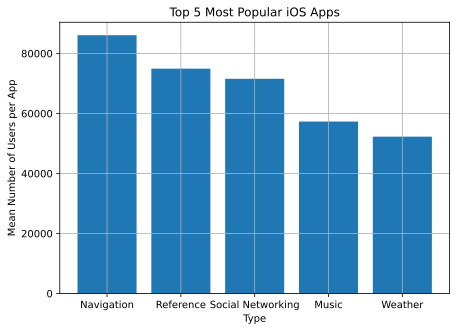

In [20]:
def users_by_type(df, type_col, users_col, moct = "mean"):
    
    """Return a Series that maps each app type to
    the average number of users per app for that type.
    Specify 'mean' or 'median' for the measure of central tendency."""
    
    dct = {}
    
    for index, row in df.iterrows():
        app_type = row[type_col]
        users = row[users_col]
        
        dct.setdefault(app_type, []).append(users)
    
    dct2 = {}
    
    for app_type in dct:
        counts = dct[app_type]
        if moct == "mean":
            dct2[app_type] = np.mean(counts)
        elif moct == "median":
            dct2[app_type] = np.median(counts)
        
    result = pd.Series(dct2).sort_values(ascending = False)
    return result

ios_users = users_by_type(ios_clean, "prime_genre", "rating_count_tot")

print(ios_users)

bar_n(
    ios_users,
    "Top 5 Most Popular iOS Apps",
    "Mean Number of Users per App",
)

The top 5 iOS app types with the highest mean average number of users per app are Navigation, Reference, Social Networking, Music, and Weather.

However, these mean averages may be skewed by a few particularly popular apps. For example, let us look at the number of users of the top 5 Navigation apps.

track_name
Waze - GPS Navigation, Maps & Real-time Traffic     345046.0
Google Maps - Navigation & Transit                  154911.0
Geocaching®                                          12811.0
CoPilot GPS – Car Navigation & Offline Maps           3582.0
ImmobilienScout24: Real Estate Search in Germany       187.0
Railway Route Search                                     5.0
Name: rating_count_tot, dtype: float64


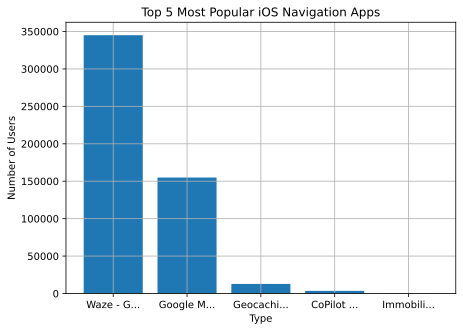

In [21]:
ios_nav = ios_clean[[
    "track_name",
    "rating_count_tot",
]].where(
    ios_clean["prime_genre"] == "Navigation"
).dropna(
).sort_values(
    by = "rating_count_tot",
    ascending = False,
).set_index(
    "track_name",
)

# `ios_nav` is still a DataFrame at this point.
# It becomes a Series below.
ios_nav = ios_nav["rating_count_tot"]

print(ios_nav)

bar_n(
    ios_nav,
    "Top 5 Most Popular iOS Navigation Apps",
    "Number of Users",
    shorten = True,
)

Clearly, the distribution is skewed because Waze has such a high number of users. Therefore, a better measure of central tendency to use would be the median, not the mean.

Let us repeat the analysis using the median this time:

Productivity         8737.5
Navigation           8196.5
Reference            6614.0
Shopping             5936.0
Social Networking    4199.0
Music                3850.0
Health & Fitness     2459.0
Photo & Video        2206.0
Finance              1931.0
Sports               1628.0
Food & Drink         1490.5
Catalogs             1229.0
Entertainment        1197.5
Business             1150.0
Lifestyle            1111.0
Utilities            1110.0
Games                 904.0
Travel                798.5
Education             606.5
Medical               566.5
Book                  421.5
News                  373.0
Weather               289.0
dtype: float64


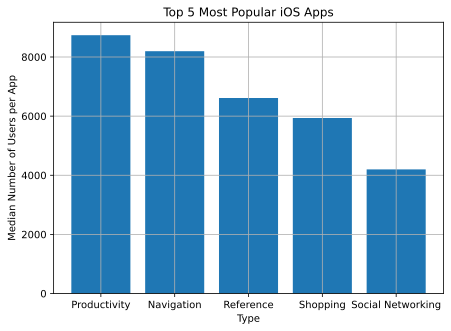

In [22]:
ios_users = users_by_type(
    ios_clean,
    "prime_genre",
    "rating_count_tot",
    moct = "median",
)

print(ios_users)

bar_n(
    ios_users,
    "Top 5 Most Popular iOS Apps",
    "Median Number of Users per App",
)

The top 5 most popular iOS apps by median number of users per app are:
- Productivity
- Navigation
- Reference
- Shopping
- Social Networking

These placements are quite different from the top 5 most common iOS apps (Games, Entertainment, Photo & Video, Education, and Social Networking).

---

**In general, we can say the following about the Apple App Store.**

- Apps for entertainment and fun, notably Games, are the most common apps.
- Apps for practical purposes, notably Productivity, are the most popular apps.

## Google Categories: Installs

Let us see which columns in the Google Play Store dataset can tell us about the number of users per app.

In [23]:
print(android_clean.iloc[0])

App               Photo Editor & Candy Camera & Grid & ScrapBook
Category                                          ART_AND_DESIGN
Rating                                                       4.1
Reviews                                                      159
Size                                                         19M
Installs                                                 10,000+
Type                                                        Free
Price                                                          0
Content Rating                                          Everyone
Genres                                              Art & Design
Last Updated                                     January 7, 2018
Current Ver                                                1.0.0
Android Ver                                         4.0.3 and up
Name: 0, dtype: object


The "Installs" column seems like the best indicator of the number of users.

In [24]:
print(android_clean["Installs"])

0            10,000+
2         5,000,000+
3        50,000,000+
4           100,000+
5            50,000+
            ...     
10836         5,000+
10837           100+
10838         1,000+
10839         1,000+
10840    10,000,000+
Name: Installs, Length: 8864, dtype: object


The column contains strings which indicate the general range of how many users installed the apps. Since we cannot find the exact number of installs, we will simply remove the "+" signs and convert the numbers into integers.

In [25]:
android_clean["Installs"] = [int(re.sub("[,+]", "", text))
                            for text in android_clean["Installs"]]

print(android_clean["Installs"])

0           10000
2         5000000
3        50000000
4          100000
5           50000
           ...   
10836        5000
10837         100
10838        1000
10839        1000
10840    10000000
Name: Installs, Length: 8864, dtype: int64


Let us now see which app categories are most popular. We will use the median average here, as we did for iOS apps.

ENTERTAINMENT          1000000.0
EDUCATION              1000000.0
GAME                   1000000.0
PHOTOGRAPHY            1000000.0
SHOPPING               1000000.0
WEATHER                1000000.0
VIDEO_PLAYERS          1000000.0
COMMUNICATION           500000.0
FOOD_AND_DRINK          500000.0
HEALTH_AND_FITNESS      500000.0
HOUSE_AND_HOME          500000.0
PRODUCTIVITY            100000.0
PERSONALIZATION         100000.0
PARENTING               100000.0
SOCIAL                  100000.0
TOOLS                   100000.0
TRAVEL_AND_LOCAL        100000.0
SPORTS                  100000.0
ART_AND_DESIGN          100000.0
MAPS_AND_NAVIGATION     100000.0
FAMILY                  100000.0
AUTO_AND_VEHICLES       100000.0
COMICS                  100000.0
BOOKS_AND_REFERENCE      50000.0
BEAUTY                   50000.0
NEWS_AND_MAGAZINES       50000.0
LIBRARIES_AND_DEMO       10000.0
FINANCE                  10000.0
DATING                   10000.0
LIFESTYLE                10000.0
MEDICAL   

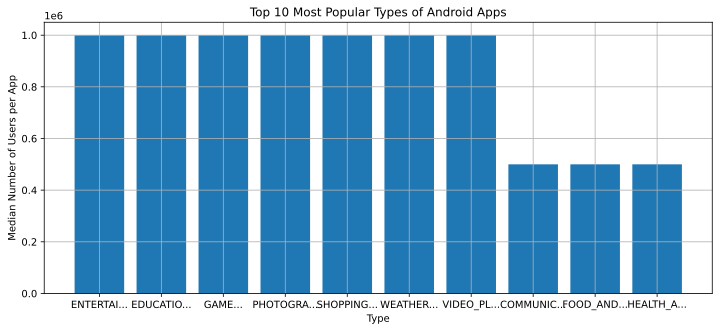

In [26]:
android_users = users_by_type(
    android_clean,
    "Category",
    "Installs",
    moct = "median",
)

print(android_users)

bar_n(
    android_users,
    "Top 10 Most Popular Types of Android Apps",
    "Median Number of Users per App",
    n = 10,
    shorten = True,
)

Since the top 5 spots all had the same median number of users per app (1000000), the graph was expanded to include the top 10 spots.

It appears that the types of Android apps with the highest median number of users per app are:

- GAME
- VIDEO_PLAYERS
- WEATHER
- EDUCATION
- ENTERTAINMENT
- PHOTOGRAPHY
- SHOPPING

---

In general, we can say the following about the Google Play Store:

- Both fun apps and practical apps are very common.
- The most popular apps are also a mix of fun apps and practical apps.

# App Profile Ideas

Based on the results, we can now determine a profitable app profile for the hypothetical app company.

Here is a summary of the findings on the 2 app stores.

- The Google Play Store has a **balanced mix** of fun and practical apps, so we can pick either kind.
- On the other hand, the Apple App Store appears to be **oversaturated with game apps**, and **practical apps are more popular**.

Therefore, in order to get the most users, the app company can set themselves apart in the Apple App Store by developing a useful **practical app**.

The most popular types of practical apps for the Apple App Store would be:

- Productivity
- Navigation
- Reference
- Shopping

For the Google Play Store, these would be:

- Weather
- Education
- Photography
- Shopping

Shopping appears in both lists, so it may be the most profitable type of app. However, the app company would have to make a unique app that has an edge over existing popular shopping apps. The same would apply for making a navigation app.

Considering that Reference and Education apps are popular, perhaps these two types could be combined into one app. First, let us find out the titles of the most popular apps in these genres.

track_name
Bible                                                 985920.0
Dictionary.com Dictionary & Thesaurus                 200047.0
Dictionary.com Dictionary & Thesaurus for iPad         54175.0
Google Translate                                       26786.0
Muslim Pro: Ramadan 2017 Prayer Times, Azan, Quran     18418.0
Name: rating_count_tot, dtype: float64


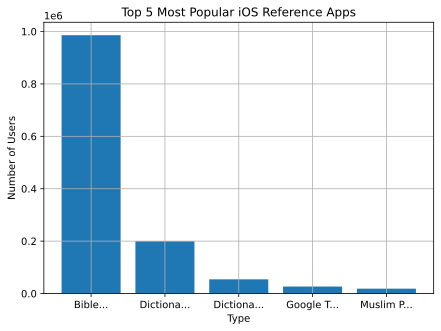

In [27]:
reference_popularity = ios_clean[["track_name", "rating_count_tot"]].where(
    ios_clean["prime_genre"] == "Reference"
).dropna(
).sort_values(
    "rating_count_tot",
    ascending = False,
).set_index(
    "track_name",
)["rating_count_tot"]

print(reference_popularity[:5])

bar_n(
    reference_popularity,
    "Top 5 Most Popular iOS Reference Apps",
    "Number of Users",
    shorten = True,
)

App
Quizlet: Learn Languages & Vocab with Flashcards      10000000.0
Learn languages, grammar & vocabulary with Memrise    10000000.0
Learn English with Wlingua                            10000000.0
Remind: School Communication                          10000000.0
Math Tricks                                           10000000.0
Name: Installs, dtype: float64


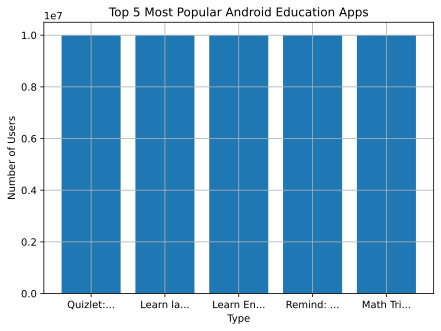

In [28]:
education_popularity = android_clean[["App", "Installs"]].where(
    android_clean["Category"] == "EDUCATION"
).dropna(
).sort_values(
    "Installs",
    ascending = False,
).set_index(
    "App",
)["Installs"]

print(education_popularity[:5])

bar_n(
    education_popularity,
    "Top 5 Most Popular Android Education Apps",
    "Number of Users",
    shorten = True,
)

The most popular Reference apps are the Bible and some dictionary and translation apps. The most popular Education apps teach languages (especially English), or Math.

Therefore, the following are some ideas of a profitable app:

- An app containing the Bible, another religious text, or another well-known text. The app can additionally include reflections and theology/spirituality courses.
- An app that contains an English dictionary, a translator, and some quick guides on English vocabulary and grammar.
    - An app like the above, but for a different language that is spoken by many people.
- An app that teaches English and Math lessons. Perhaps it could be marketed as a practice app for an entrance exam.

# Conclusion

In this project, we analyzed app data from a Google Play Store dataset and an Apple App Store dataset. Apps were limited to free apps targeted towards English speakers, because the hypothetical app company makes these kinds of apps. The most common and popular app genres were determined.

In the end, several ideas of profitable apps were listed. The app company may now review the analysis and consider the suggestions. This may help them make an informed, data-driven decision regarding the next app that they will develop.